In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *
from scripts.mane_utils import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]

In [118]:
def plot_browser_isos(ca, sg, gene,
                      obs_col, obs_condition, 
                      filt_ab, pp_summary, 
                      major_set,
                      h=0.1, w=56, fig_w=14, species='human',
                      add_tss=False,
                      add_ccre=False,
                      major=False,
                      order='expression',
                      light_shade=None,
                      dark_shade=None):
    """
    Plot browser style isoform models for a given sample
    """

    def plot_tss(ca, sg, tpm_df, x, y, h, ax):
        tpm_df = add_feat(tpm_df, kind='tss', col='transcript_id')
        tpm_df.head()
        tss_df = ca.tss.loc[ca.tss.Name.isin(tpm_df.tss.tolist())]
        tss_df.head()
        regions = [(entry.Start, entry.End) for ind, entry in tss_df.iterrows()]
        color = get_sector_colors()[0]['tss']
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
        return ax
    
    def plot_cds(entry, sg, x, y, h, ax):
        c_dict = get_cds_colors()
        
#         def get_inc_region(entry, how, scale):
#             inc = 55000*scale
#             if how == 'start' and entry.Strand == '+':
#                 col = 'CDS_Start'
#             elif how == 'stop' and entry.Strand == '+':
#                 col = 'CDS_Stop'
#             elif how == 'start' and entry.Strand == '-':
#                 col = 'CDS_Stop'
#             elif how == 'stop' and entry.Strand == '-':
#                 col = 'CDS_Start'
#             if entry.Strand == '+':
#                 regions = (entry[col],entry[col]+inc)
#             elif entry.Strand == '-':
#                 regions = (entry[col],entry[col]-inc)
#             regions = [regions]
#             print(f'Scale: {scale}')
#             print(f'CDS inc: {inc}')
            
#             return regions 

        # get start and stop 
        pdb.set_trace()
    
        if entry.Strand == '+':
            orf_start = 'CDS_Start'
            orf_stop = 'CDS_Stop'
        elif entry.Strand == '-':
            orf_stop = 'CDS_Start'
            orf_start = 'CDS_Stop'

        # iterate through exons
        loc_path = sg.pg.loc_path
        exons = [(sg.pg.loc_df.loc[v1, 'coord'],
            sg.pg.loc_df.loc[v2, 'coord']) \
            for v1,v2 in zip(loc_path[:-1],loc_path[1:])][::2]
        
        
        # start codon
        color = c_dict['start']
        regions = get_inc_region(entry, 'start', sg.pg.scale)
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
        
        # stop codon
        color = c_dict['stop']
        regions = get_inc_region(entry, 'stop', sg.pg.scale)
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
       
        return ax
        

    def plot_ccre(ca, sg, x, y, h, ax):

        # ccre regions
        sources = ['pls', 'pels', 'dels']
        ccre = ca.tss_map.loc[ca.tss_map.source.isin(sources)].copy(deep=True)

        # get ranges w/i this region
        min_coord = sg.pg.g_min
        max_coord = sg.pg.g_max
        chrom = sg.pg.chrom

        ccre['min_coord'] = ccre[['Start', 'End']].min(axis=1)
        ccre['max_coord'] = ccre[['Start', 'End']].max(axis=1)

        # subset on regions
        ccre = pr.PyRanges(ccre)
        region = pr.from_dict({'Chromosome': [chrom],
                                        'Start': [min_coord],
                                        'End': [max_coord]})
        ccre = ccre.intersect(region, strandedness=None)
        ccre = ccre.as_df()

        # colors
        c_dict, _ = get_ccre_colors()
        colors = [c_dict[s] for s in ccre.source.tolist()]
        regions = [(entry.Start, entry.End) for ind, entry in ccre.iterrows()]
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, colors, ax)

        return ax

    def get_major_isos(major_set, gene, sample=None):
        """
        Get list of major isfoorms in a given sample
        """
        df = pd.read_csv(major_set, sep='\t')
        df = df.loc[df.gname == gene]
        if sample:
            df = df.loc[df['sample'] == sample]
        tids = df.tid.unique().tolist()
        return tids

    def get_isos(ca, filt_ab, gene, sample, species):
        df = pd.read_csv(filt_ab, sep='\t')
        df = get_det_table(df,
                       groupby='sample',
                       how='iso',
                       min_tpm=1,
                       gene_subset='polya',
                       species=species)
        df = df.loc[sample]
        df = df.to_frame()
        df = df.loc[df[sample]==True]
        gid = ca.triplets.loc[ca.triplets.gname==gene, 'gid'].values[0]
        df.reset_index(inplace=True)
        df['gid'] = df['index'].str.split('[', expand=True)[0]
        df = df.loc[df.gid == gid]
        tids = df['index'].tolist()
        return tids


    def get_tpm_df(sg, tids, obs_col, obs_condition):
        tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
        tpm_df = tpm_df.transpose()
        tpm_df = tpm_df.loc[tids, obs_condition].to_frame()
        return tpm_df

    if major:
        tids = get_major_isos(major_set, gene, obs_condition)
    else:
        tids = get_isos(ca, filt_ab, gene, obs_condition, species)
    tpm_df = get_tpm_df(sg, tids, obs_col, obs_condition)

    # colormap definition
    if not light_shade:
        light_shade = get_sector_colors()[0]['mixed']
    if not dark_shade:
        dark_shade = get_sector_colors()[0]['simple']
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', [light_shade, dark_shade])


    # # font sizes
    # # small_text = 6/(6.11/16)
    # small_text = 20.3
    # big_text = 6.71/(6.11/16)
    # # print('small text size: {}'.format(small_text))
    # # print('big text size: {}'.format(big_text))


#     # height spacing b/w models
#     if not h_space:
#         h_space = h*1.75
#     # print('h_space : {}'.format(h_space))
#     # print('h: {}'.format(h))

#     # plotting settings
#     fig_len = len(tids)
#     fig_len += 1 # for scale
#     if add_tss:
#         fig_len += 1
#     if add_ccre:
#         fig_len += 1
#     fig_h = h_space*(fig_len-1)+h
#     fig_h += 0.3 # vertical spacing adjustment
#     # print('fig h: {}'.format(fig_h))
#     # print('fig w: {}'.format(fig_w))
    
    # trying to make this work w/ heatmap
    # plt.figure(1, figsize=(fig_w, fig_h), frameon=False)
    # ax = plt.gca()
    
    fig_h = len(tids)/4
    
    w1_rat = (fig_w/6)*2
    w2_rat = (fig_w/6)*4
    fig, (ax, ax2) = plt.subplots(1,2, figsize=(fig_w, fig_h),
                                  gridspec_kw={'width_ratios':(w1_rat, w2_rat)},
                                  frameon=False, sharey=True)
    fig.subplots_adjust(wspace=0.00)
    fig.subplots_adjust(hspace=0.00)
    
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42

    # plotting order
    tpm_df = tpm_df.sort_values(by=obs_condition, ascending=False)
    tpm_df = tpm_df[[obs_condition]]

    if order == 'tss':
        tpm_df = add_feat(tpm_df, kind='tss', col='index')
        tpm_df.sort_values(by=['tss', obs_condition], ascending=[True, False], inplace=True)
        tpm_df.drop('tss', axis=1, inplace=True)

    # add reference ids
    if species == 'human':
        ref_source = 'v40'
    elif species == 'mouse':
        ref_source = 'vM25'
    df = ca.t_map.loc[ca.t_map.source == ref_source]
    df = df[['transcript_id','original_transcript_id', 'original_transcript_name']]
    tpm_df = tpm_df.merge(df, how='left', left_index=True, right_on='transcript_id')

    # clean up for transcripts that aren't known
    df = ca.t_map.loc[ca.t_map.source == 'lapa']
    df = df[['gene_name', 'transcript_id', 'transcript_name',
             'tss_id', 'ic_id', 'tes_id']].drop_duplicates()
    tpm_df = tpm_df.merge(df, how='left', on='transcript_id')
    tpm_df.fillna('N/A', inplace=True)

    if species == 'human':
        refs = ['v40', 'v29']
    elif species == 'mouse':
        refs = ['vM21', 'vM25']
    known_tids = ca.t_map.loc[ca.t_map.source.isin(refs)].transcript_id.unique().tolist()
    tpm_df.loc[tpm_df.transcript_id.isin(known_tids), 'Known_str'] = '*'
    tpm_df['Known'] = tpm_df.transcript_id.isin(known_tids)
    

    # triplets rather than entire transcript name
    tpm_df['triplet'] = tpm_df.transcript_id.str.split('[', n=1, expand=True)[1]
    tpm_df['triplet'] = tpm_df.triplet.str.split(']', n=1, expand=True)[0]
    tpm_df['triplet'] = '['+tpm_df.triplet+']'
    
    # NMD and ORF 
    pp_df = pd.read_csv(pp_summary, sep='\t')
    pp_df.rename({'tid': 'transcript_id'}, axis=1, inplace=True)
    tpm_df = tpm_df.merge(pp_df[['transcript_id', 'nmd', 'full_orf', 
                                 'seq', 'Strand', 'CDS_Start', 'CDS_Stop']], 
                          how='left', 
                          on='transcript_id')
    
    # are these the mane orf
    if species == 'human':
        tpm_df['gid'] = tpm_df['ic_id'].str.split('_', expand=True)[0]
        gid = tpm_df.gid.values[0]
        mane_orf = get_mane_orf(pp_summary,
                                'v40_cerberus',
                                gid=gid).seq.values[0]
        tpm_df['is_mane_orf'] = tpm_df['seq'] == mane_orf        
    
    def add_bool_heatmap(tpm_df, ax):
        keep_cols = ['triplet', 'gene_name', 'is_mane_orf',
                     'full_orf', 'nmd', 'Known']
        temp = tpm_df[keep_cols]
        temp['iso_trip'] = temp.gene_name+' '+temp.triplet
        temp.drop(['triplet', 'gene_name'], axis=1, inplace=True)
        temp.set_index('iso_trip', inplace=True)
        temp.index.name = ''
        temp.rename({'is_mane_orf': 'MANE ORF',
                     'full_orf': 'Full ORF',
                     'nmd': 'NMD'}, axis=1, inplace=True)
        # bool_cols = ['is_mane_orf', 'full_orf', 'nmd', 'Known']
        bool_cols = ['MANE ORF', 'Full ORF', 'NMD', 'Known']
        temp2 = pd.DataFrame()

        m = {True: '*', False: ''}
        for c in bool_cols:
            new_col = c+'_str'
            temp2[new_col] = temp[c].map(m)

        ax = sns.heatmap(temp, cbar=False, cmap='Purples',
                         linewidths=0.5, linecolor='k',
                         annot=temp2, square=True, 
                         fmt='', ax=ax)
        ax.tick_params(left=False,
                       right=False, labelright=False,
                       bottom=False, labelbottom=False,
                       labeltop=True)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        return ax
    
    # first add the labels
    ax = add_bool_heatmap(tpm_df, ax)
    
    # get y coords from heatmap
    y_locs = ax.get_yticks()
    
    # get x coords from heatmap
    x = 0    
    i = 0
    # tpm_df = tpm_df.iloc[::-1]
    for index, entry in tpm_df.iterrows():
        
        y_ytick = y_locs[i]

        # y coords
        # y = (len(tpm_df.index) - i)*(h_space)
        y = y_ytick-(h/2)

        # tid
        tid = entry['transcript_id']
        # color by TPM
        if len(tpm_df.index) == 1:
            norm_val = entry[obs_condition]
        else:
            norm_val = (entry[obs_condition]-tpm_df[obs_condition].min())/(tpm_df[obs_condition].max()-tpm_df[obs_condition].min())
        color = cmap(norm_val)
        
        # plot models + cds
        ax2 = sg.plot_browser(tid, y=y, x=x, h=h, w=w, color=color,
                              ax=ax2, linewidth=1.5)
        plot_cds(entry, sg, x, y, h, ax2)
        
        i+=1
        
    plt.tight_layout()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_frame_on(False)     
    
    return ax, tpm_df

In [119]:
def plot_browser_isos_2(h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        gene,
                        obs_col,
                        obs_condition,
                        ofile,
                        h=0.2,
                        **kwargs):
    
    ca = cerberus.read(h5)
    sg = swan.read(swan_file)

    ax, tpm_df = plot_browser_isos(ca,
                                   sg,
                                   gene,
                                   obs_col,
                                   obs_condition,
                                   filt_ab,
                                   pp_summary,
                                   major_isos,
                                   h=h,
                                   w=40,
                                   **kwargs)
    plt.savefig(ofile, dpi=500)

    return ax, tpm_df

In [120]:
# ca = cerberus.read(cerberus_h5)
# sg = swan.read(swan_file)

In [ ]:
ax, tpm_df = plot_browser_isos(ca,
                               sg,
                               'PKM',
                               obs_col,
                               'ovary',
                               filt_ab,
                               pp_summary,
                               major_isos,
                               h=0.6,
                               w=10,
                               fig_w=6)
plt.savefig('piss_my_pants.pdf', dpi=300)
# ax, tpm_df = plot_browser_isos_2(cerberus_h5,
#                     swan_file, 
#                     filt_ab,
#                     pp_summary,
#                     major_isos,
#                     'PKM',
#                     obs_col,
#                     'ovary',
#                     'figures/pkm_ovary_browser_isos.pdf',
#                     fig_w=8,
#                     h=0.3)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
> <ipython-input-118-b79a131f49a7>(66)plot_cds()
     64 
     65         # start codon
---> 66         color = c_dict['start']
     67         regions = get_inc_region(entry, 'start', sg.pg.scale)
     68         ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)



ipdb>  orf_start


*** NameError: name 'orf_start' is not defined


ipdb>  entry.strand


*** AttributeError: 'Series' object has no attribute 'strand'


ipdb>  entry


ovary                                                              459.809631
transcript_id                                          ENSG00000067225[1,1,1]
original_transcript_id                                     ENST00000335181.10
original_transcript_name                                              PKM-202
gene_name                                                                 PKM
transcript_name                                                    PKM[1,1,1]
tss_id                                                      ENSG00000067225_1
ic_id                                                       ENSG00000067225_1
tes_id                                                      ENSG00000067225_1
Known_str                                                                   *
Known                                                                    True
triplet                                                               [1,1,1]
nmd                                                             

ipdb>  entry.Strand


'-'


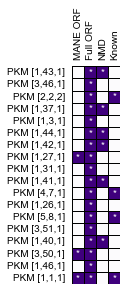

In [39]:
def add_bool_heatmap(tpm_df, ax):
    keep_cols = ['triplet', 'gene_name', 'is_mane_orf', 'full_orf', 'nmd', 'Known']
    temp = tpm_df[keep_cols]
    temp['iso_trip'] = temp.gene_name+' '+temp.triplet
    temp.drop(['triplet', 'gene_name'], axis=1, inplace=True)
    temp.set_index('iso_trip', inplace=True)
    temp.index.name = ''
    temp.rename({'is_mane_orf': 'MANE ORF',
                 'full_orf': 'Full ORF',
                 'nmd': 'NMD'}, axis=1, inplace=True)
    # bool_cols = ['is_mane_orf', 'full_orf', 'nmd', 'Known']
    bool_cols = ['MANE ORF', 'Full ORF', 'NMD', 'Known']
    temp2 = pd.DataFrame()

    m = {True: '*', False: ''}
    # annot_kws = dict()
    for c in bool_cols:
        new_col = c+'_str'
        temp2[new_col] = temp[c].map(m)
        # annot_kws[c] = new_col

    temp.head()
    temp2.head()

    ax = sns.heatmap(temp, cbar=False, cmap='Purples',
                     linewidths=0.5, linecolor='k',
                     annot=temp2, square=True, 
                     fmt='', ax=ax)
    ax.tick_params(left=False,
                   right=False, labelright=False,
                   bottom=False, labelbottom=False,
                   labeltop=True)
    _ = plt.xticks(rotation=90)
    
    return ax


ax = plt.gca()
ax = add_bool_heatmap(tpm_df, ax)

In [ ]:
ytickslocs = ax.get_yticks()
ytickslocs

In [8]:
xtickslocs = ax.get_xticks()
xtickslocs



array([0.5, 1.5, 2.5, 3.5])

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples


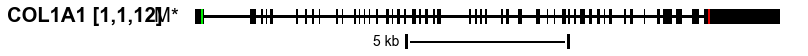

In [7]:
plot_browser_isos_2(cerberus_h5,
                    swan_file, 
                    filt_ab,
                    pp_summary,
                    major_isos,
                    'COL1A1',
                    obs_col,
                    'ovary',
                    'figures/pkm_ovary_browser_isos.pdf',
                    h=0.2,
                    ref_sources=['v29', 'v40'])